<p align = "center"><strong>LOCAL SPATIAL AUTOCORRELATION: GEARY C <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Geary’s Index (Local Geary C)__

__Def.__  

Medida **Local de autocorrelación espacial** que cuantifica el grado de **disimilitud espacial** entre el valor de una unidad espacial y los valores de sus unidades vecinas, de acuerdo con una matriz de pesos espaciales.  
A diferencia del índice de Moran, el índice de Geary es **más sensible a variaciones locales**.

El índice toma valores :
- $\to$ __0__ fuerte autocorrelación espacial positiva (valores similares)

- $\approx$ __1__ ausencia de autocorrelación espacial local

- $\to$ __> 1__ autocorrelación espacial negativa (valores disímiles)


__Formula:__

Desviaciones respecto la media
$$
z_i = x_i - \bar{x} \qquad z_j = x_j - \bar{x}
\qquad \bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i
$$ 

Índice de Geary Local
$$
C_i =
\frac{1}{2\,s^2}
\sum_{j=1}^{n} w_{ij} (x_i - x_j)^2
$$

donde
$$
s^2 = \frac{1}{n-1}\sum_{k=1}^{n}(x_k-\bar{x})^2
$$


<p align = 'center'> 
<em>El índice de Geary Local permite identificar contrastes espaciales locales, siendo especialmente útil para detectar fronteras espaciales y discontinuidades.</em>
</p>


donde : 
- $w_{ij}$ elemento de la matrix de pesos espaciales $W$.
- $x_i$ valor observado de la variable de interés en la unidad espacial $i$.
- $x_j$ valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$).
- $n$ número de unidades espaciales.
- $s^2$ varianza muestral global de la variable.
- $C_i$ estadístico local de Geary para la unidad espacial $i$.


__Reference:__
- Geary, R. C. (1954). *The contiguity ratio and statistical mapping*. The Incorporated Statistician, 5(3), 115–145.  
  https://www.jstor.org/stable/2986645


---


In [ ]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import geopandas as gpd
from libpysal.weights import Queen, Rook, W, lag_spatial

from esda.geary import Geary               # Global Geary 
from esda.geary_local import Geary_Local   # Local Geary

import warnings


def local_geary(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_x: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_field: str | None = None,
    seed: int | None = None,
):
    """
    Local Geary for MULTIPLE variables and 3 contiguities (Queen/Rook/Bishop).

    Returns:
      - results_table: long table with Global Geary C + Local-Geary significance & cluster counts
      - fig: Dashboard for ONE variable (dashboard_field):
             (1) scatter: z(x) vs lag(z(x)) [diagnostic], with Global Geary C in title
             (2) Local Geary significance map (p bins)
             (3) Local Geary cluster map (GeoDa-like: HH, LL, Other Positive, Negative)
             repeated for each contiguity (rows)
      - out: dict with detailed objects for the dashboard_field

    Notes:
      - GeoDa uses row-standardized weights -> w.transform="R"
      - Local Geary "cluster map" here follows a GeoDa-like logic:
            significant (p<=alpha) AND localG < mean(localG)  -> "positive/similar":
                HH if z>0 & wz>0
                LL if z<0 & wz<0
                else Other Positive
            significant (p<=alpha) AND localG >= mean(localG) -> Negative (dissimilar)
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    missing = [c for c in fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # Default dashboard variable
    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # STYLE AND WARNINGS
    plt.style.use(style)

    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )

    # HELPERS
    def build_w(df, kind):
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)
        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)
        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)
            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)
            return W(neighbors, id_order=ids)
        raise ValueError("kind must be queen/rook/bishop")

    def zscore(x):
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    # PRECOMPUTE WEIGHTS PER CONTIGUITY (with islands handling)
    kinds = list(contiguities)
    by_kind = {}

    for kind in kinds:
        df2 = gdf.copy()
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))

        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)

        w.transform = "R"
        by_kind[kind] = {"gdf": df2, "w": w, "islands_initial": islands_initial}

    # RESULTS TABLE
    rows = []

    for field in fields:
        for kind in kinds:
            df2 = by_kind[kind]["gdf"]
            w = by_kind[kind]["w"]
            islands_initial = by_kind[kind]["islands_initial"]

            x = df2[field].to_numpy()

            if len(x) < 3 or np.std(x, ddof=0) == 0:
                rows.append({
                    "variable": field,
                    "contiguity": kind.upper(),
                    "n": int(len(x)),
                    "global_C": np.nan,
                    "global_p_perm": np.nan,
                    "permutations": int(permutations),
                    "alpha": float(alpha),
                    "islands_initial": int(len(islands_initial)),
                    "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                    "islands_remaining": int(len(getattr(w, "islands", []))),
                    "sig_0_not": np.nan,
                    "sig_1_p05": np.nan,
                    "sig_2_p01": np.nan,
                    "sig_3_p001": np.nan,
                    "HH": np.nan,
                    "LL": np.nan,
                    "Other_Pos": np.nan,
                    "Negative": np.nan,
                    "note": "n<3 or zero variance",
                })
                continue

            # Global Geary (para reporte)
            gc_global = Geary(x, w, permutations=permutations)

            # Local Geary
            lg = Geary_Local(
                connectivity=w,
                permutations=permutations,
                sig=alpha,
                seed=seed,
                drop_islands=drop_islands,
                labels=False
            ).fit(x)

            p = lg.p_sim
            localG = lg.localG

            # Significance bins
            sig_class = np.zeros_like(p, dtype=int)
            sig_class[(p <= 0.05) & (p > 0.01)] = 1
            sig_class[(p <= 0.01) & (p > 0.001)] = 2
            sig_class[p <= 0.001] = 3

            sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

            # --- Cluster map GeoDa-like REAL (compatible con GeoDa) ---

            # z-score (GeoDa estandariza)
            z = zscore(x) if standardize_x else x.copy()

            # vecinos por observación (usamos la estructura de w)
            ids = list(w.id_order)
            pos = {id_: k for k, id_ in enumerate(ids)}

            # promedio simple de vecinos (NO lag_spatial)
            nbr_mean = np.full(len(ids), np.nan, dtype=float)
            for i_id in ids:
                i = pos[i_id]
                nbrs = w.neighbors.get(i_id, [])
                if len(nbrs) == 0:
                    nbr_mean[i] = np.nan
                else:
                    jj = [pos[j_id] for j_id in nbrs]
                    nbr_mean[i] = np.mean(z[jj])

            # umbral de GeoDa: media de localG
            Eij_mean = float(np.mean(localG))

            sig_alpha = p <= alpha
            positive = sig_alpha & (localG < Eij_mean)
            negative = sig_alpha & (localG >= Eij_mean)

            cl_class = np.zeros_like(p, dtype=int)
            # 0 Not Significant
            # 1 High-High
            # 2 Low-Low
            # 3 Other Positive
            # 4 Negative

            # Positive spatial association
            cl_class[positive & (z > 0) & (nbr_mean > 0)] = 1  # HH
            cl_class[positive & (z < 0) & (nbr_mean < 0)] = 2  # LL
            cl_class[positive & ~( (z > 0) & (nbr_mean > 0) ) & ~( (z < 0) & (nbr_mean < 0) )] = 3  # Other Positive

            # Negative spatial association
            cl_class[negative] = 4

            cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

            rows.append({
                "variable": field,
                "contiguity": kind.upper(),
                "n": int(len(x)),
                "global_C": float(gc_global.C),
                "global_p_perm": float(getattr(gc_global, "p_sim", np.nan)),
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": int(sig_counts[0]),
                "sig_1_p05": int(sig_counts[1]),
                "sig_2_p01": int(sig_counts[2]),
                "sig_3_p001": int(sig_counts[3]),
                "HH": int(cl_counts[1]),
                "LL": int(cl_counts[2]),
                "Other_Pos": int(cl_counts[3]),
                "Negative": int(cl_counts[4]),
                "note": "",
            })

    results_table = pd.DataFrame(rows)

    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["variable", "contiguity"]).reset_index(drop=True)

    # DASHBOARD palettes + legends
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b", "#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)

    cl_labels = ["Not Significant", "High-High", "Low-Low", "Other Positive", "Negative"]
    cl_colors = ["#f0f0f0", "#8b0000", "#f4a261", "#f6d2b8", "#2b6cb0"]
    cl_cmap = ListedColormap(cl_colors)

    out = {"dashboard_field": dashboard_field, "by_contiguity": {}}

    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])

    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]

        x = df2[dashboard_field].to_numpy()

        # Global Geary (for scatter title)
        gc_global = Geary(x, w, permutations=permutations)

        # Local Geary
        lg = Geary_Local(
            connectivity=w,
            permutations=permutations,
            sig=alpha,
            seed=seed,
            drop_islands=drop_islands,
            labels=False
        ).fit(x)

        p = lg.p_sim
        localG = lg.localG

        # Scatter: z(x) vs lag(z(x))  (diagnostic)
        x_plot = zscore(x) if standardize_x else x.copy()
        wx_plot = lag_spatial(w, x_plot)

        ax_sc = axes[r, 0]
        ax_sc.scatter(x_plot, wx_plot, edgecolor="k", facecolor="none", s=25)
        ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.set_title(
            f"{kind.upper()} — z(x) vs lag(z(x)) (Global C={gc_global.C:.3f}, p={gc_global.p_sim:.4f})",
            fontweight="bold",
        )
        ax_sc.set_xlabel(f"{dashboard_field} ({'std' if standardize_x else 'raw'})")
        ax_sc.set_ylabel("Spatial lag")

        # Significance classes
        sig_class = np.zeros_like(p, dtype=int)
        sig_class[(p <= 0.05) & (p > 0.01)] = 1
        sig_class[(p <= 0.01) & (p > 0.001)] = 2
        sig_class[p <= 0.001] = 3
        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

        # --- Cluster map GeoDa-like REAL (compatible con GeoDa) ---

        # z-score (GeoDa estandariza)
        z = zscore(x) if standardize_x else x.copy()

        # vecinos por observación (usamos la estructura de w)
        ids = list(w.id_order)
        pos = {id_: k for k, id_ in enumerate(ids)}

        # promedio simple de vecinos (NO lag_spatial)
        nbr_mean = np.full(len(ids), np.nan, dtype=float)
        for i_id in ids:
            i = pos[i_id]
            nbrs = w.neighbors.get(i_id, [])
            if len(nbrs) == 0:
                nbr_mean[i] = np.nan
            else:
                jj = [pos[j_id] for j_id in nbrs]
                nbr_mean[i] = np.mean(z[jj])

        # umbral de GeoDa: media de localG
        Eij_mean = float(np.mean(localG))

        sig_alpha = p <= alpha
        positive = sig_alpha & (localG < Eij_mean)
        negative = sig_alpha & (localG >= Eij_mean)

        cl_class = np.zeros_like(p, dtype=int)
        # 0 Not Significant
        # 1 High-High
        # 2 Low-Low
        # 3 Other Positive
        # 4 Negative

        # Positive spatial association
        cl_class[positive & (z > 0) & (nbr_mean > 0)] = 1  # HH
        cl_class[positive & (z < 0) & (nbr_mean < 0)] = 2  # LL
        cl_class[positive & ~( (z > 0) & (nbr_mean > 0) ) & ~( (z < 0) & (nbr_mean < 0) )] = 3  # Other Positive

        # Negative spatial association
        cl_class[negative] = 4


        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class

        # Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(f"{kind.upper()} — Local Geary Significance (perms={permutations})", fontweight="bold")
        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k",
                  label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True)

        # Cluster map
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(f"{kind.upper()} — Local Geary Cluster (α={alpha})", fontweight="bold")
        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k",
                  label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(5)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True)

        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "x": x,
            "geary_global": gc_global,
            "geary_local": lg,
            "x_plot": x_plot,
            "wx_plot": wx_plot,
            "islands_initial": islands_initial,
            "Eij_mean": Eij_mean,
        }

    fig.suptitle(f"LOCAL GEARY — {dashboard_field}", y=1.02, fontsize=14, fontweight="bold")
    fig.tight_layout()

    return results_table, fig, out


In [ ]:
# Import data 
gdf = gpd.read_file("../healthindicators/HealthIndicators.shp")

,variable,contiguity,n,global_C,global_p_perm,permutations,alpha,islands_initial,islands_removed,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,HH,LL,Other_Pos,Negative,note
0,Below_evel,QUEEN,77,0.534916,0.001,999,0.05,0,0,0,51,17,8,1,4,14,2,6,
1,Below_evel,ROOK,77,0.530751,0.001,999,0.05,0,0,0,53,13,9,2,5,12,1,6,
2,Below_evel,BISHOP,31,0.699182,0.102,999,0.05,46,46,0,30,1,0,0,0,1,0,0,
3,BirthRate,QUEEN,77,0.682042,0.001,999,0.05,0,0,0,60,9,6,2,9,7,0,1,
4,BirthRate,ROOK,77,0.668361,0.001,999,0.05,0,0,0,58,12,3,4,10,8,0,1,
5,BirthRate,BISHOP,31,0.892096,0.352,999,0.05,46,46,0,29,2,0,0,0,1,0,1,
6,TeenB_Rate,QUEEN,77,0.445842,0.001,999,0.05,0,0,0,50,15,7,5,13,11,0,3,
7,TeenB_Rate,ROOK,77,0.445264,0.001,999,0.05,0,0,0,51,15,7,4,12,10,1,3,
8,TeenB_Rate,BISHOP,31,0.689231,0.099,999,0.05,46,46,0,28,2,0,1,1,1,0,1,
9,Unemp_ment,QUEEN,77,0.507256,0.001,999,0.05,0,0,0,42,18,11,6,10,17,3,5,


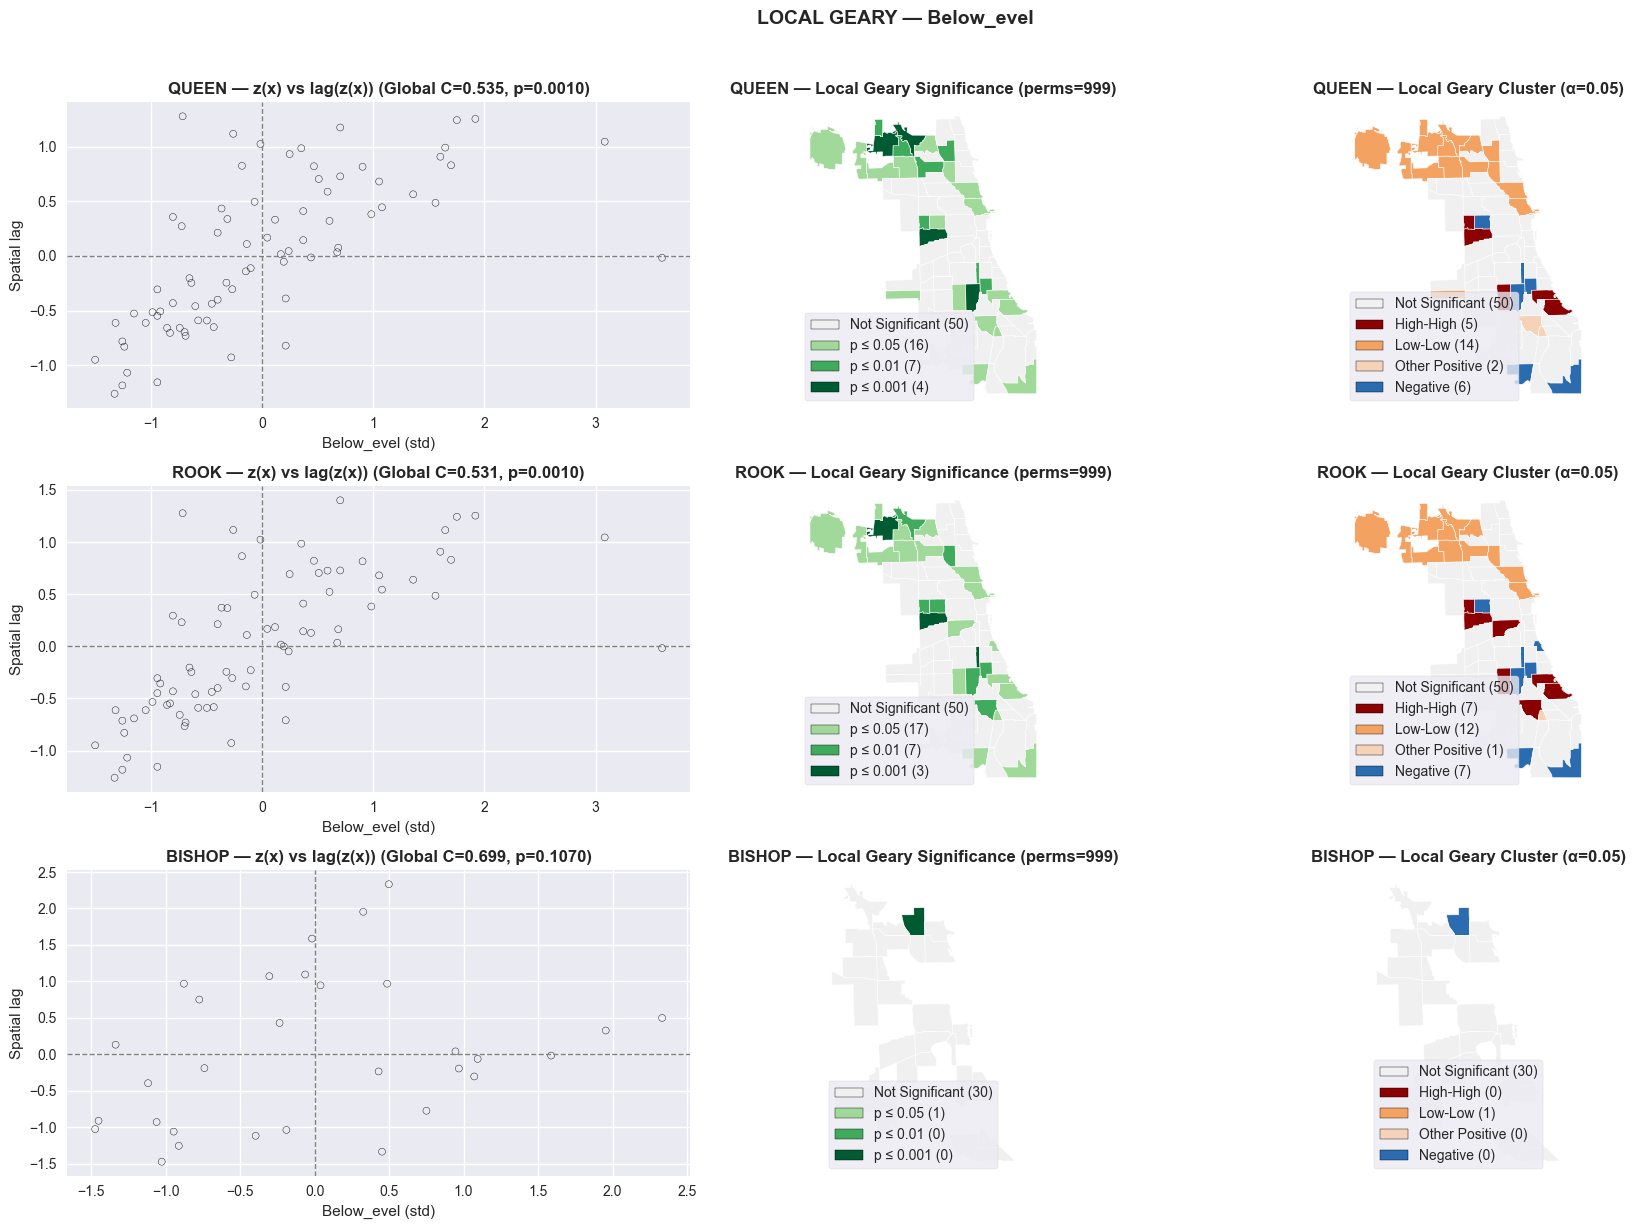

In [36]:
# Inputs
fields = ["Unemp_ment", "Below_evel", "BirthRate", "TeenB_Rate"]

table, fig, out = local_geary(
    gdf,
    fields,
    permutations=999,
    alpha=0.05,
    dashboard_field="Below_evel",
)

display(table)
plt.show()

---
